In [148]:
"""
Unified UTA Pipeline: Monotonic and Non-Monotonic Implementation
Based on Ghaderi et al. (2017) EJOR paper
"""

import numpy as np
from typing import Sequence, Optional, Dict, Any, Tuple, List
from gurobipy import Model, GRB, LinExpr
import warnings

In [149]:
# ==================== SCALING UTILITIES ====================

def _scale_matrix(X: np.ndarray, mode: Optional[str]) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Column-wise scaling.
    mode in {None, 'minmax', 'sym', 'zscore'}:
      - minmax/unitrange: [0,1]
      - sym: [-1,1]
      - zscore: (x-mean)/std (breaks built on observed min/max of z)
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape
    meta = {"mode": mode, "params": []}
    if mode is None:
        return X.copy(), meta

    Xs = np.empty_like(X)
    for j in range(m):
        col = X[:, j].astype(float)
        if mode in ("minmax", "unitrange"):
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = (col - mn) / rng
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "sym":
            mn, mx = float(col.min()), float(col.max())
            rng = mx - mn if mx > mn else 1.0
            Xs[:, j] = 2.0 * (col - mn) / rng - 1.0
            meta["params"].append({"min": mn, "max": mx})
        elif mode == "zscore":
            mu, sd = float(col.mean()), float(col.std(ddof=0))
            sd = sd if sd > 0 else 1.0
            Xs[:, j] = (col - mu) / sd
            meta["params"].append({"mean": mu, "std": sd})
        else:
            raise ValueError("Unknown scaling mode.")
    return Xs, meta


def _scale_with_info(X, scale_info):
    """Apply scaling using stored scale_info parameters"""
    mode = scale_info.get("mode")
    if not mode:
        return X
    X = np.asarray(X, dtype=float).copy()
    params = scale_info["params"]
    for j in range(X.shape[1]):
        if mode in ("minmax", "unitrange"):
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = (X[:, j] - mn) / rng
        elif mode == "sym":
            mn, mx = params[j]["min"], params[j]["max"]
            rng = (mx - mn) if mx > mn else 1.0
            X[:, j] = 2.0 * (X[:, j] - mn) / rng - 1.0
        elif mode == "zscore":
            mu, sd = params[j]["mean"], params[j]["std"]
            sd = sd if sd > 0 else 1.0
            X[:, j] = (X[:, j] - mu) / sd
        else:
            raise ValueError("Unknown scaling mode in scale_info.")
    return X

In [150]:
# ==================== BREAKPOINT & INTERPOLATION ====================

def _build_breaks(minv: float, maxv: float, L: int) -> np.ndarray:
    """Build L equidistant breakpoints between minv and maxv"""
    if L < 2:
        raise ValueError("L must be >= 2.")
    return np.linspace(minv, maxv, L)


def _interp_expr(m: Model, x: float, brk: np.ndarray, uvars: List[Any]) -> LinExpr:
    """
    Linear interpolation of u(x) over breakpoints brk and decision values uvars.
    Returns a Gurobi affine expression.
    """
    if x <= brk[0]:
        return LinExpr(uvars[0])
    if x >= brk[-1]:
        return LinExpr(uvars[-1])

    j = np.searchsorted(brk, x) - 1
    j = max(0, min(j, len(brk)-2))
    x0, x1 = float(brk[j]), float(brk[j+1])
    w1 = (x - x0) / (x1 - x0)
    w0 = 1.0 - w1
    expr = LinExpr()
    expr.addTerms([w0, w1], [uvars[j], uvars[j+1]])
    return expr

In [151]:
# ==================== GROUND TRUTH GENERATOR ====================

def uta_gt(
    X: np.ndarray,
    L: int,
    seed: Optional[int] = None,
    weights_dirichlet_alpha: float = 1.0,
    increments_dirichlet_alpha: float = 1.0,
    scale: Optional[str] = "minmax",
    non_monotonic_criteria: Optional[List[int]] = None,
    non_monotonic_complexity: int = 2,
) -> Dict[str, Any]:
    """
    Generate additive model (monotonic or non-monotonic).

    For MONOTONIC criteria:
      - weights w ~ Dirichlet(alpha)
      - each marginal u_k is PWL with L points; increments ~ Dirichlet => monotone
      - u_k(min)=0, u_k(max)=1

    For NON-MONOTONIC criteria (Ghaderi et al. approach):
      - Generate "sweet spot" marginals (inverted-U or U-shaped)
      - Complexity controlled by non_monotonic_complexity parameter

    Parameters
    ----------
    X : np.ndarray, shape (n, m)
        Alternatives data
    L : int
        Number of breakpoints per criterion
    non_monotonic_criteria : List[int], optional
        Indices of criteria that should be non-monotonic
    non_monotonic_complexity : int
        Degree of non-monotonicity (1=linear, 2=quadratic/sweet-spot, etc.)

    Returns
    -------
    dict with: weights, u_values (m x L), breaks, scores, ranking, is_monotonic (per criterion)
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=float)
    n, m = X.shape

    if non_monotonic_criteria is None:
        non_monotonic_criteria = []

    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    w = rng.dirichlet(np.full(m, weights_dirichlet_alpha))
    u_values = np.zeros((m, L))
    is_monotonic = np.ones(m, dtype=bool)

    for j in range(m):
        if j in non_monotonic_criteria:
            # NON-MONOTONIC: Generate "sweet spot" (inverted-U shape)
            is_monotonic[j] = False
            # Use polynomial to create sweet-spot shape
            t = np.linspace(0, 1, L)
            if non_monotonic_complexity == 2:
                # Quadratic sweet spot (peak in middle)
                # u_raw = 4 * t * (1 - t) #peaks at t=0.5
                # u_values[j] = u_raw / u_raw.max()  # normalize to 0,1
                u_values[j] = 4 * t * (1 - t)
            else:
                # Higher-order polynomial
                coeffs = rng.uniform(-1, 1, non_monotonic_complexity + 1)
                poly = np.poly1d(coeffs)
                u_raw = poly(t)
                # Normalize to [0, 1]
                u_raw = u_raw - u_raw.min()
                u_max = u_raw.max()
                u_values[j] = u_raw / u_max if u_max > 0 else u_raw
        else:
            # MONOTONIC: Standard UTA approach
            inc = rng.dirichlet(np.full(L-1, increments_dirichlet_alpha))
            u_values[j, 0] = 0.0
            u_values[j, 1:] = np.cumsum(inc)

    # Compute scores
    scores = np.zeros(n)
    for a in range(n):
        s = 0.0
        for j in range(m):
            x = float(Xs[a, j])
            brk = breaks[j]
            if x <= brk[0]:
                u = u_values[j, 0]
            elif x >= brk[-1]:
                u = u_values[j, -1]
            else:
                t = np.searchsorted(brk, x) - 1
                t = max(0, min(t, L-2))
                lam = (x - brk[t]) / (brk[t+1] - brk[t])
                u = (1 - lam) * u_values[j, t] + lam * u_values[j, t+1]
            s += w[j] * u
        scores[a] = s

    order = np.argsort(-scores).tolist()
    return {
        "scale_info": scale_info,
        "breaks": breaks,
        "u_values": u_values,
        "weights": w,
        "scores": scores,
        "ranking": order,
        "is_monotonic": is_monotonic,
        "non_monotonic_criteria": non_monotonic_criteria,
    }

In [152]:
# ==================== UNIFIED INFERENCE ====================

def uta_inf(
    X: np.ndarray,
    order: Optional[Sequence[int]],
    L: int,
    scale: Optional[str] = "minmax",
    eps: float = 1e-2,
    min_increment: float = 0.0,
    assume_rows_are_ordered: bool = False,
    non_monotonic_criteria: Optional[List[int]] = None,
    gamma_weight: float = 0.5,
    gamma_upper_bound: float = 2.0,
    use_non_monotonic: bool = False,
    gurobi_params: Optional[Dict[str, Any]] = None,
    verbose: bool = False,
) -> Dict[str, Any]:
    """
    Unified inference for BOTH monotonic and non-monotonic criteria.

    **(Ghaderi et al.):**
    - For non-monotonic criteria, we remove monotonicity constraints
    - We control complexity by minimizing slope variation (gamma variables)
    - Objective balances discriminatory power (epsilon) vs complexity (gamma)

    Parameters
    ----------
    X : np.ndarray, shape (n, m)
        Alternatives performance matrix
    order : Sequence[int]
        Strict preference order (best to worst)
    L : int
        Number of breakpoints per criterion
    non_monotonic_criteria : List[int], optional
        Indices of criteria to treat as non-monotonic
    gamma_weight : float, default=0.5
        Weight for complexity term in objective (0.5 = equal weight as in paper)
        Higher values (>0.5) prefer simpler functions
    gamma_upper_bound : float, default=2.0
        Upper bound for gamma variables (from Ghaderi paper analysis)
    use_non_monotonic : bool, default=False
        If True, uses non-monotonic formulation; if False, uses standard monotonic UTA

    Model (Non-Monotonic):
    ---------------------
    Decision variables:
      - u_{j,l} : Value at breakpoint l for criterion j (can be negative for non-monotonic)
      - gamma_{j,l} : Slope variation at breakpoint l for criterion j
      - o[a] : Slack variables for soft constraints
      - epsilon : Separation margin

    Objective (Ghaderi et al. Eq. 13):
      minimize: gamma_weight * log(sum gamma) - (1 - gamma_weight) * log(epsilon)

    This is equivalent to minimizing (sum gamma) / epsilon for gamma_weight = 0.5

    Returns
    -------
    dict with: status, obj, scores, order, breaks, u_values, weights, scale_info,
               is_monotonic (per criterion), gamma_values, method_used
    """
    X = np.asarray(X, dtype=float)
    n, m = X.shape

    if non_monotonic_criteria is None:
        non_monotonic_criteria = []

    if order is None:
        if not assume_rows_are_ordered:
            raise ValueError("Provide a strict 'order' or set assume_rows_are_ordered=True.")
        order = list(range(n))
    else:
        order = list(order)
        if len(order) != n or len(set(order)) != n:
            raise ValueError("`order` must be a permutation of range(n) with no duplicates (strict).")

    Xs, scale_info = _scale_matrix(X, scale)
    breaks = [_build_breaks(Xs[:, j].min(), Xs[:, j].max(), L) for j in range(m)]

    # Track which criteria are monotonic
    is_monotonic = np.ones(m, dtype=bool)
    for j in non_monotonic_criteria:
        is_monotonic[j] = False

    model = Model("UTA_Unified")
    if not verbose:
        model.setParam("OutputFlag", 0)
    if gurobi_params:
        for k, v in gurobi_params.items():
            model.setParam(k, v)

    # Decision variables: u_{j,l}
    u = []
    for j in range(m):
        if is_monotonic[j] and not use_non_monotonic:
            # Monotonic: u >= 0
            uj = [model.addVar(lb=0.0, name=f"u_{j}_{l}") for l in range(L)]
        else:
            # Non-monotonic: u unrestricted (but bounded for numerical stability)
            uj = [model.addVar(lb=-10.0, ub=10.0, name=f"u_{j}_{l}") for l in range(L)]
        u.append(uj)

    # Slack variables
    o = [model.addVar(lb=0.0, name=f"o_{a}") for a in range(n)]

    # Epsilon variable for discriminatory power
    epsilon_var = model.addVar(lb=0.01, ub=0.5, name="epsilon")

    # Gamma variables for slope variation (Ghaderi et al. Eq. 10)
    gamma = []
    if use_non_monotonic:
        for j in range(m):
            gamma_j = [model.addVar(lb=0.0, ub=gamma_upper_bound,
                                   name=f"gamma_{j}_{l}") for l in range(L-1)]
            gamma.append(gamma_j)

    model.update()

    # ========== CONSTRAINTS ==========

    # 1) Normalization constraints
    for j in range(m):
        model.addConstr(u[j][0] == 0.0, name=f"norm_min_{j}")

    # 2) Monotonicity constraints (only for monotonic criteria)
    for j in range(m):
        if is_monotonic[j] and not use_non_monotonic:
            for l in range(L-1):
                model.addConstr(u[j][l+1] - u[j][l] >= min_increment,
                              name=f"mono_{j}_{l}")

    # 3) Slope variation constraints (Ghaderi et al. Eq. 10)
    if use_non_monotonic:
        for j in range(m):
            for l in range(L-1):
                # Get interval lengths
                delta_left = float(breaks[j][l] - breaks[j][l-1]) if l > 0 else 1.0
                delta_right = float(breaks[j][l+1] - breaks[j][l])

                if l == 0:
                    # First interior breakpoint: only right slope matters
                    slope_right = (u[j][l+1] - u[j][l]) / delta_right
                    model.addConstr(slope_right <= gamma[j][l], name=f"gamma_u_{j}_{l}")
                    model.addConstr(-slope_right <= gamma[j][l], name=f"gamma_l_{j}_{l}")
                else:
                    # Interior breakpoints: measure slope variation
                    slope_left = (u[j][l] - u[j][l-1]) / delta_left
                    slope_right = (u[j][l+1] - u[j][l]) / delta_right
                    slope_diff = slope_right - slope_left

                    model.addConstr(slope_diff <= gamma[j][l], name=f"gamma_u_{j}_{l}")
                    model.addConstr(-slope_diff <= gamma[j][l], name=f"gamma_l_{j}_{l}")

    # 4) Bounding constraints for non-monotonic (Ghaderi et al. Eq. 11)
    if use_non_monotonic:
        for j in range(m):
            for l in range(L):
                model.addConstr(u[j][l] >= 0.0, name=f"bound_low_{j}_{l}")
                model.addConstr(u[j][l] <= 1.0, name=f"bound_up_{j}_{l}")

    # 5) Sum of maxima = 1 (weights normalization)
    model.addConstr(sum(u[j][-1] for j in range(m)) == 1.0, name="sum_weights")

    # 6) Compute utilities
    U = []
    for a in range(n):
        expr = LinExpr()
        for j in range(m):
            expr += _interp_expr(model, float(Xs[a, j]), breaks[j], u[j])
        U.append(expr)

    # 7) Strict order constraints (using epsilon_var)
    for k in range(n - 1):
        a, b = order[k], order[k + 1]
        model.addConstr(U[a] - U[b] >= epsilon_var + o[b] - o[a],
                       name=f"adj_strict_{a}_{b}")

    # ========== OBJECTIVE ==========
    if use_non_monotonic and len(gamma) > 0:
        # Ghaderi et al. approach: minimize (sum gamma) / epsilon
        total_gamma = sum(sum(gamma[j]) for j in range(m))
        total_slacks = sum(o)

        # Weighted objective balancing complexity vs discriminatory power
        # gamma_weight = 0.5 gives equal importance (as in paper's LFP formulation)
        obj = gamma_weight * total_gamma - (1 - gamma_weight) * epsilon_var + total_slacks

        model.setObjective(obj, GRB.MINIMIZE)
    else:
        # Standard monotonic UTA: minimize slacks
        model.setObjective(sum(o), GRB.MINIMIZE)

    model.optimize()

    # ========== EXTRACT RESULTS ==========
    if model.status != GRB.OPTIMAL:
        warnings.warn(f"Optimization status: {model.status}")
        return {
            "status": model.status,
            "obj": None,
            "scores": None,
            "ranking": None,
            "method_used": "non-monotonic" if use_non_monotonic else "monotonic",
        }

    # Extract u values
    u_values = np.zeros((m, L))
    for j in range(m):
        for l in range(L):
            u_values[j, l] = u[j][l].X

    # Extract gamma values (if non-monotonic)
    gamma_values = None
    if use_non_monotonic and len(gamma) > 0:
        gamma_values = np.zeros((m, L-1))
        for j in range(m):
            for l in range(L-1):
                gamma_values[j, l] = gamma[j][l].X

    # Compute scores
    scores = np.zeros(n)
    for a in range(n):
        s = 0.0
        for j in range(m):
            x = float(Xs[a, j])
            brk = breaks[j]
            if x <= brk[0]:
                u_val = u_values[j, 0]
            elif x >= brk[-1]:
                u_val = u_values[j, -1]
            else:
                t = np.searchsorted(brk, x) - 1
                t = max(0, min(t, L-2))
                lam = (x - brk[t]) / (brk[t+1] - brk[t])
                u_val = (1 - lam) * u_values[j, t] + lam * u_values[j, t+1]
            s += u_values[j, -1] * u_val
        scores[a] = s

    inferred_order = np.argsort(-scores).tolist()
    weights = u_values[:, -1]

    return {
        "status": model.status,
        "obj": model.ObjVal,
        "scores": scores,
        "ranking": inferred_order,
        "breaks": breaks,
        "u_values": u_values,
        "weights": weights,
        "scale_info": scale_info,
        "is_monotonic": is_monotonic,
        "gamma_values": gamma_values,
        "epsilon": epsilon_var.X if use_non_monotonic else None,
        "method_used": "non-monotonic" if use_non_monotonic else "monotonic",
        "non_monotonic_criteria": non_monotonic_criteria,
    }

In [153]:
# ==================== SCORING FUNCTION ====================

def make_scoring_fn(model):
    """
    Create scoring function from inferred model.
    Works for both monotonic and non-monotonic models.
    """
    w = np.asarray(model["weights"])
    uvals = np.asarray(model["u_values"])
    brks = model["breaks"]
    sinfo = model.get("scale_info", {"mode": None})

    def U(X):
        X = np.atleast_2d(X).astype(float)
        Xs = _scale_with_info(X, sinfo)

        scores = np.zeros(X.shape[0])
        for j in range(X.shape[1]):
            uj = np.interp(Xs[:, j], brks[j], uvals[j])
            scores += w[j] * uj
        return scores

    return U

In [154]:
# ==================== VISUALIZATION ====================

def plot_value_functions(gt: dict, res: dict, mode: str = "weighted"):
    """
    Plot value functions (True vs Inferred) with support for non-monotonic shapes.

    Parameters
    ----------
    mode : {"weighted", "shape"}
        - "weighted": plot w_j * u_j(x)
        - "shape": normalize each marginal by its max
    """
    import matplotlib.pyplot as plt

    m = len(gt["breaks"])
    if m != len(res["breaks"]):
        raise ValueError("Mismatch in number of criteria.")

    rows = (m + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, 3*rows))
    axes = np.ravel(axes) if rows > 1 else np.array([axes]).ravel()

    for j, ax in enumerate(axes[:m]):
        # True
        x_true = np.asarray(gt["breaks"][j], float)
        u_true = np.asarray(gt["u_values"][j], float)
        # Inferred
        x_inf = np.asarray(res["breaks"][j], float)
        u_inf = np.asarray(res["u_values"][j], float)

        if mode == "weighted":
            w_t = float(gt["weights"][j])
            w_i = float(res["weights"][j])
            y_true = w_t * u_true
            y_inf = w_i * u_inf
            y_label = r"$w_j \cdot u_j(x)$"
            title_suffix = "Weighted"
        elif mode == "shape":
            y_true = u_true / (u_true.max() if u_true.max() > 0 else 1.0)
            y_inf = u_inf / (u_inf.max() if u_inf.max() > 0 else 1.0)
            y_label = "Normalized partial utility"
            title_suffix = "Shape"
        else:
            raise ValueError("mode must be 'weighted' or 'shape'.")

        # Plot
        ax.plot(x_true, y_true, marker='o', linewidth=2, label='True')
        ax.plot(x_inf, y_inf, marker='s', linestyle='--', linewidth=2, label='Inferred')

        # Add monotonicity indicator
        is_mono_gt = gt.get("is_monotonic", np.ones(m, dtype=bool))[j]
        is_mono_inf = res.get("is_monotonic", np.ones(m, dtype=bool))[j]
        mono_str = ""
        if not is_mono_gt:
            mono_str = " [GT: Non-mono]"
        if not is_mono_inf:
            mono_str += " [Inf: Non-mono]"

        ax.set_title(f"C{j+1} ({title_suffix}){mono_str}", fontsize=10)
        ax.set_xlim(x_true.min(), x_true.max())
        ymax = max(y_true.max(), y_inf.max()) if y_true.size and y_inf.size else 1.0
        ax.set_ylim(0, 1.1 * ymax if ymax > 0 else 1.0)
        ax.set_xlabel("Criterion value (scaled)")
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)
        ax.legend()

    for ax in axes[m:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_weights(gt: dict, res: dict):
    """Side-by-side bar plot of True vs Inferred weights"""
    import matplotlib.pyplot as plt

    w_true = np.asarray(gt["weights"], float)
    w_inf = np.asarray(res["weights"], float)
    if w_true.shape != w_inf.shape:
        raise ValueError("Weight vectors have different shapes.")

    m = len(w_true)
    idx = np.arange(m)
    barw = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(idx - barw/2, w_true, width=barw, label="True")
    plt.bar(idx + barw/2, w_inf, width=barw, label="Inferred")
    plt.xticks(idx, [f"C{i+1}" for i in range(m)])
    plt.xlabel("Criterion")
    plt.ylabel("Weight")
    plt.title("Weights: True vs Inferred")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_gamma_heatmap(res: dict):
    """
    Visualize slope variation (gamma values) for non-monotonic inference.
    Shows which breakpoints have the most slope variation.
    """
    import matplotlib.pyplot as plt

    if res.get("gamma_values") is None:
        print("No gamma values available (monotonic inference or not computed)")
        return

    gamma_vals = res["gamma_values"]
    m, L_minus_1 = gamma_vals.shape

    fig, ax = plt.subplots(figsize=(10, max(3, m * 0.6)))
    im = ax.imshow(gamma_vals, aspect='auto', cmap='YlOrRd')

    ax.set_xticks(np.arange(L_minus_1))
    ax.set_yticks(np.arange(m))
    ax.set_xticklabels([f"BP{l}" for l in range(1, L_minus_1+1)])
    ax.set_yticklabels([f"C{j+1}" for j in range(m)])
    ax.set_xlabel("Breakpoint")
    ax.set_ylabel("Criterion")
    ax.set_title("Slope Variation (Gamma) Heatmap")

    plt.colorbar(im, ax=ax, label="Gamma value")
    plt.tight_layout()
    plt.show()

In [155]:
# ==================== EVALUATION PROTOCOL ====================

def pairwise_agreement_once(
    n=100, m=4, L=5, n_pairs=10_000,
    seed=None,
    use_non_monotonic=False,
    non_monotonic_criteria=None
):
    """
    Single run: GT -> INF -> evaluate on n_pairs -> compute agreement
    """
    rng = np.random.default_rng(seed)

    X = rng.integers(0, 1000, size=(n, m))

    # Ground truth
    gt = uta_gt(X, L=L, seed=int(rng.integers(0, 1_000_000)),
                non_monotonic_criteria=non_monotonic_criteria)
    U_gt = make_scoring_fn(gt)
    ranking_ref = gt["ranking"]

    # Inference
    inf = uta_inf(X, order=ranking_ref, L=L, eps=1e-4,
                  use_non_monotonic=use_non_monotonic,
                  non_monotonic_criteria=non_monotonic_criteria)
    U_inf = make_scoring_fn(inf)

    # Generate test pairs
    XY = rng.integers(0, 1000, size=(n_pairs, 2, m))
    Xp, Yp = XY[:, 0, :], XY[:, 1, :]

    cmp_gt = np.sign(U_gt(Xp) - U_gt(Yp))
    cmp_inf = np.sign(U_inf(Xp) - U_inf(Yp))

    return float((cmp_gt == cmp_inf).mean())


def run_protocol(
    n=100, m=4, L=5, n_pairs=10_000, repeats=30, seed=42,
    use_non_monotonic=False, non_monotonic_criteria=None
):
    """
    Complete protocol: multiple repetitions with confidence intervals
    """
    rng = np.random.default_rng(seed)
    accs = [
        pairwise_agreement_once(
            n=n, m=m, L=L, n_pairs=n_pairs,
            seed=int(rng.integers(0, 1_000_000)),
            use_non_monotonic=use_non_monotonic,
            non_monotonic_criteria=non_monotonic_criteria
        )
        for _ in range(repeats)
    ]
    accs = np.array(accs)
    return {
        "mean_acc": float(accs.mean()),
        "std_acc": float(accs.std(ddof=1)),
        "runs": repeats,
        "per_run": accs.tolist(),
    }

MONOTONIC UTA
Ground truth weights: [0.325 0.315 0.322 0.038]
Ground truth ranking (top 10): [47, 34, 15, 7, 2, 19, 39, 23, 24, 8]

Inferred weights: [0.315 0.323 0.307 0.055]
Optimization status: 2
Objective value: 0.807583
Inferred ranking (top 10): [47, 34, 15, 7, 2, 24, 19, 39, 23, 8]

Generating visualizations...


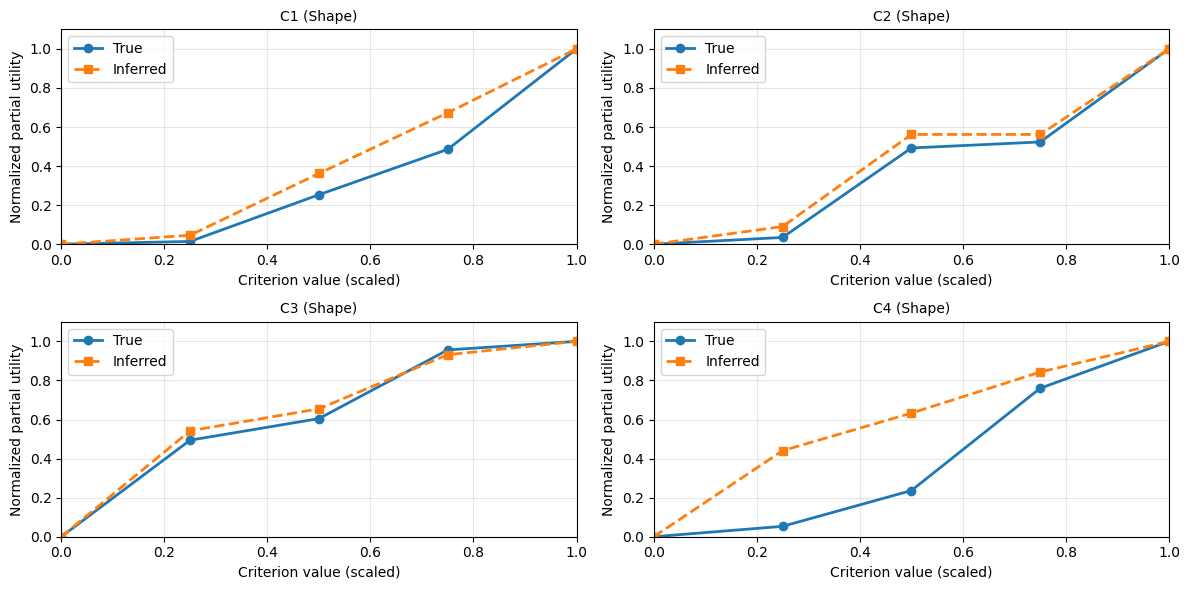

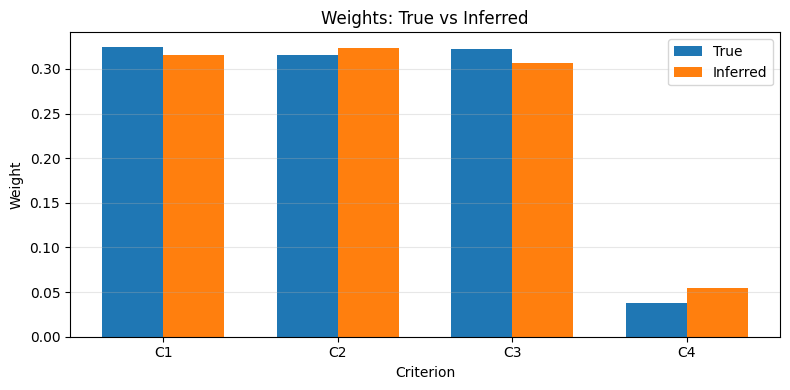

In [156]:
# ==================== MONOTONIC UTA ====================

# Generate synthetic data
np.random.seed(42)
n, m, L = 50, 4, 5
X = np.random.randint(0, 100, size=(n, m))

print("="*60)
print("MONOTONIC UTA")
print("="*60)

# Generate monotonic ground truth
gt_mono = uta_gt(X, L=L, seed=42)
print(f"Ground truth weights: {np.round(gt_mono['weights'], 3)}")
print(f"Ground truth ranking (top 10): {gt_mono['ranking'][:10]}")

# Infer monotonic model
res_mono = uta_inf(X, order=gt_mono['ranking'], L=L, eps=1e-4, use_non_monotonic=False)
print(f"\nInferred weights: {np.round(res_mono['weights'], 3)}")
print(f"Optimization status: {res_mono['status']}")
print(f"Objective value: {res_mono['obj']:.6f}")
print(f"Inferred ranking (top 10): {res_mono['ranking'][:10]}")

# Visualize monotonic results
print("\nGenerating visualizations...")
plot_value_functions(gt_mono, res_mono, mode="shape")
plot_weights(gt_mono, res_mono)

NON-MONOTONIC UTA (Ghaderi et al.)
Ground truth weights: [0.469 0.092 0.198 0.242]
Non-monotonic criteria: [1, 2]
Is monotonic per criterion: [ True False False  True]
Ground truth ranking (top 10): [39, 23, 20, 46, 47, 34, 2, 27, 15, 14]

Inferred weights: [0.678 0.    0.    0.322]
Optimization status: 2
Objective value: 3.061230
Epsilon (separation): 0.010000
Inferred ranking (top 10): [34, 47, 14, 27, 20, 23, 7, 15, 46, 39]

Max gamma value: 1.0336
Total slope variation: 3.9099

Generating visualizations...


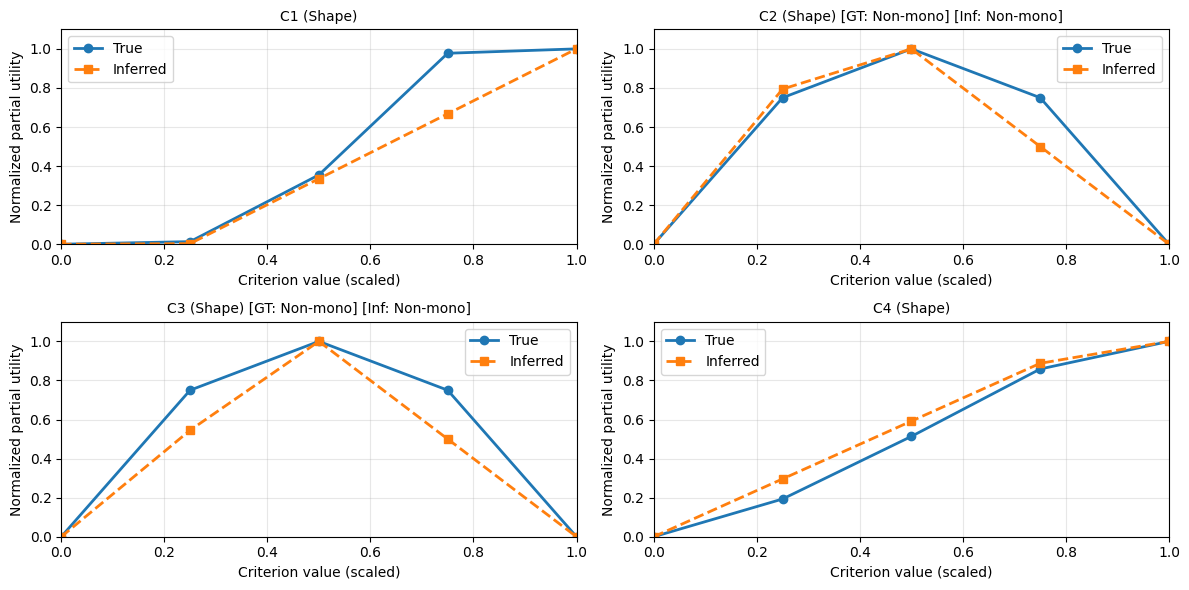

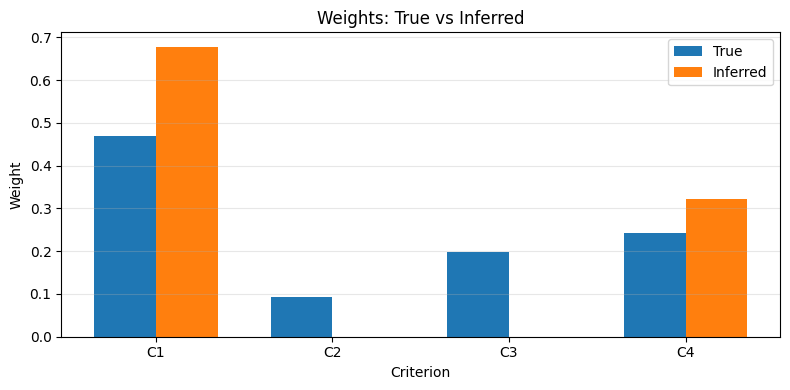

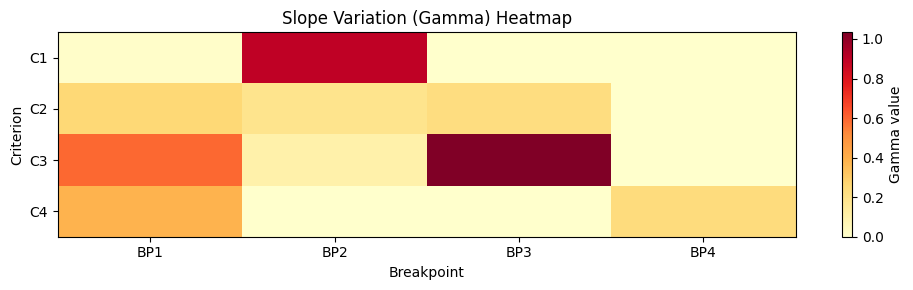

In [157]:
# ==================== NON-MONOTONIC UTA (Ghaderi et al.) ====================

# Use same data as monotonic example
np.random.seed(42)
n, m, L = 50, 4, 5
X = np.random.randint(0, 100, size=(n, m))

print("="*60)
print("NON-MONOTONIC UTA (Ghaderi et al.)")
print("="*60)

# Specify that criteria 1 and 2 are non-monotonic (sweet-spot type)
non_mono_criteria = [1, 2]

# Generate non-monotonic ground truth
gt_nonmono = uta_gt(X, L=L, seed=123,
                    non_monotonic_criteria=non_mono_criteria,
                    non_monotonic_complexity=2)
print(f"Ground truth weights: {np.round(gt_nonmono['weights'], 3)}")
print(f"Non-monotonic criteria: {gt_nonmono['non_monotonic_criteria']}")
print(f"Is monotonic per criterion: {gt_nonmono['is_monotonic']}")
print(f"Ground truth ranking (top 10): {gt_nonmono['ranking'][:10]}")

# Infer non-monotonic model
res_nonmono = uta_inf(X, order=gt_nonmono['ranking'], L=L,
                      eps=0.1,  # Adjusted epsilon baseline
                      use_non_monotonic=True,
                      non_monotonic_criteria=non_mono_criteria,
                      gamma_weight=0.5,  # Balance complexity and separation
                      )

print(f"\nInferred weights: {np.round(res_nonmono['weights'], 3)}")
print(f"Optimization status: {res_nonmono['status']}")
print(f"Objective value: {res_nonmono['obj']:.6f}")
print(f"Epsilon (separation): {res_nonmono['epsilon']:.6f}")
print(f"Inferred ranking (top 10): {res_nonmono['ranking'][:10]}")

if res_nonmono['gamma_values'] is not None:
    print(f"\nMax gamma value: {np.max(res_nonmono['gamma_values']):.4f}")
    print(f"Total slope variation: {np.sum(res_nonmono['gamma_values']):.4f}")

# Visualize non-monotonic results
print("\nGenerating visualizations...")
plot_value_functions(gt_nonmono, res_nonmono, mode="shape")
plot_weights(gt_nonmono, res_nonmono)
plot_gamma_heatmap(res_nonmono)

In [158]:
# ==================== COMPREHENSIVE EVALUATION ====================

print("\n" + "="*60)
print("PAIRWISE AGREEMENT EVALUATION")
print("="*60)

# Monotonic evaluation
print("\n1. MONOTONIC UTA Performance:")
for n_alts in [10, 20, 50, 100]:
    result = run_protocol(n=n_alts, m=4, L=5, n_pairs=10_000, repeats=30,
                         use_non_monotonic=False)
    print(f"  n={n_alts:3d}: {result['mean_acc']:.3%} ± {result['std_acc']:.3%}")

# Non-monotonic evaluation
print("\n2. NON-MONOTONIC UTA Performance (criteria [1,2] non-monotonic):")
for n_alts in [10, 20, 50, 100]:
    result = run_protocol(n=n_alts, m=4, L=5, n_pairs=10_000, repeats=30,
                         use_non_monotonic=True,
                         non_monotonic_criteria=[1, 2])
    print(f"  n={n_alts:3d}: {result['mean_acc']:.3%} ± {result['std_acc']:.3%}")


PAIRWISE AGREEMENT EVALUATION

1. MONOTONIC UTA Performance:
  n= 10: 79.622% ± 7.396%
  n= 20: 90.266% ± 2.796%
  n= 50: 92.670% ± 1.658%
  n=100: 88.533% ± 3.766%

2. NON-MONOTONIC UTA Performance (criteria [1,2] non-monotonic):
  n= 10: 67.775% ± 11.046%
  n= 20: 77.092% ± 9.471%
  n= 50: 79.316% ± 8.027%
  n=100: 76.187% ± 8.029%



GAMMA WEIGHT SENSITIVITY ANALYSIS


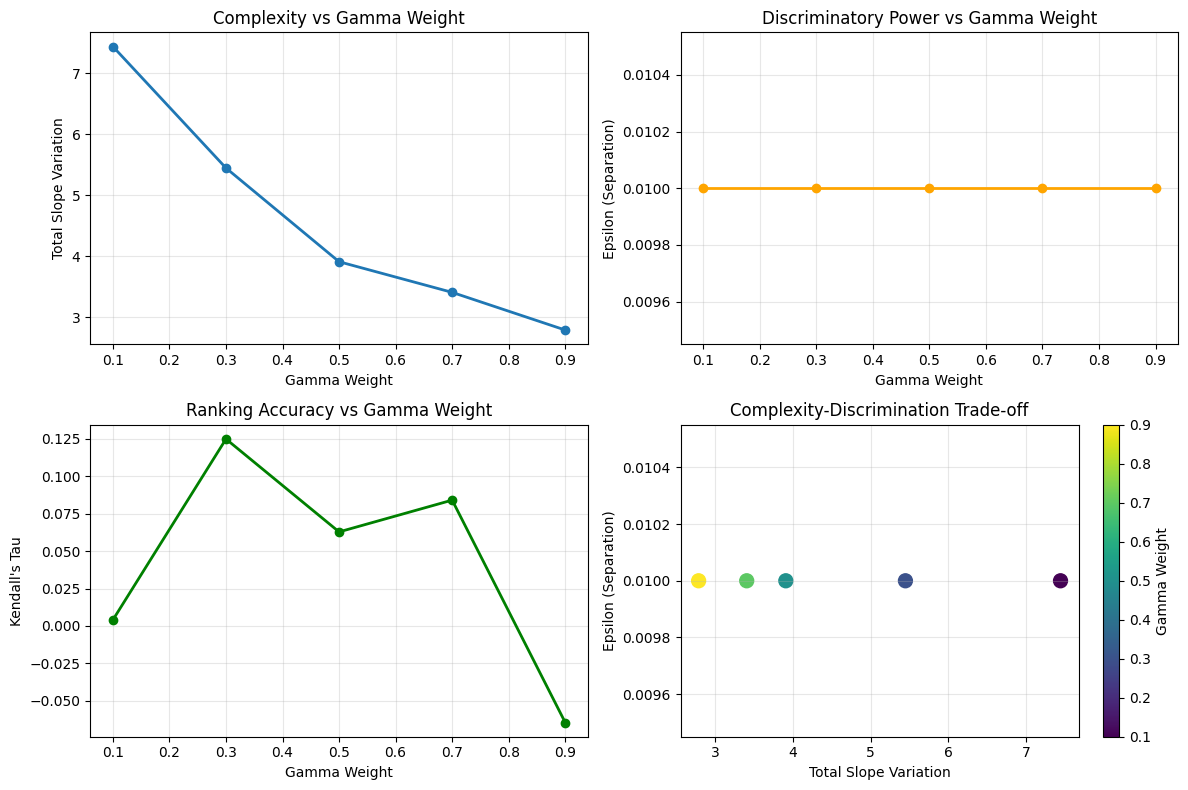


Results:
  γ_w=0.1: Σγ=7.441, ε=0.0100, τ=0.004
  γ_w=0.3: Σγ=5.448, ε=0.0100, τ=0.125
  γ_w=0.5: Σγ=3.910, ε=0.0100, τ=0.063
  γ_w=0.7: Σγ=3.407, ε=0.0100, τ=0.084
  γ_w=0.9: Σγ=2.789, ε=0.0100, τ=-0.064


In [159]:
# ==================== GAMMA WEIGHT SENSITIVITY ANALYSIS ====================

def analyze_gamma_weights(X, gt, L=5):
    """
    Analyze how different gamma_weight values affect:
    1. Model complexity (total gamma)
    2. Discriminatory power (epsilon)
    3. Ranking accuracy
    """
    import matplotlib.pyplot as plt

    gamma_weights = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    for gw in gamma_weights:
        res = uta_inf(X, order=gt['ranking'], L=L,
                 eps=0.1,  # Consistent with main call
                 use_non_monotonic=True,
                 non_monotonic_criteria=gt['non_monotonic_criteria'],
                 gamma_weight=gw,
                 verbose=False)

        if res['status'] == GRB.OPTIMAL:
            total_gamma = np.sum(res['gamma_values']) if res['gamma_values'] is not None else 0
            epsilon_val = res['epsilon'] if res['epsilon'] is not None else 0

            # Compute ranking accuracy (Kendall's tau)
            from scipy.stats import kendalltau
            tau, _ = kendalltau(gt['ranking'], res['ranking'])

            results.append({
                'gamma_weight': gw,
                'total_gamma': total_gamma,
                'epsilon': epsilon_val,
                'kendall_tau': tau,
                'obj': res['obj']
            })

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    gws = [r['gamma_weight'] for r in results]

    # Total gamma
    axes[0, 0].plot(gws, [r['total_gamma'] for r in results], 'o-', linewidth=2)
    axes[0, 0].set_xlabel('Gamma Weight')
    axes[0, 0].set_ylabel('Total Slope Variation')
    axes[0, 0].set_title('Complexity vs Gamma Weight')
    axes[0, 0].grid(True, alpha=0.3)

    # Epsilon
    axes[0, 1].plot(gws, [r['epsilon'] for r in results], 'o-', linewidth=2, color='orange')
    axes[0, 1].set_xlabel('Gamma Weight')
    axes[0, 1].set_ylabel('Epsilon (Separation)')
    axes[0, 1].set_title('Discriminatory Power vs Gamma Weight')
    axes[0, 1].grid(True, alpha=0.3)

    # Kendall's tau
    axes[1, 0].plot(gws, [r['kendall_tau'] for r in results], 'o-', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Gamma Weight')
    axes[1, 0].set_ylabel("Kendall's Tau")
    axes[1, 0].set_title('Ranking Accuracy vs Gamma Weight')
    axes[1, 0].grid(True, alpha=0.3)

    # Trade-off: complexity vs discrimination
    axes[1, 1].scatter([r['total_gamma'] for r in results],
                      [r['epsilon'] for r in results],
                      c=gws, cmap='viridis', s=100)
    axes[1, 1].set_xlabel('Total Slope Variation')
    axes[1, 1].set_ylabel('Epsilon (Separation)')
    axes[1, 1].set_title('Complexity-Discrimination Trade-off')
    axes[1, 1].grid(True, alpha=0.3)
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('Gamma Weight')

    plt.tight_layout()
    plt.show()

    return results

# Run sensitivity analysis
print("\n" + "="*60)
print("GAMMA WEIGHT SENSITIVITY ANALYSIS")
print("="*60)

sensitivity_results = analyze_gamma_weights(X, gt_nonmono, L=5)
print("\nResults:")
for r in sensitivity_results:
    print(f"  γ_w={r['gamma_weight']:.1f}: "
          f"Σγ={r['total_gamma']:.3f}, "
          f"ε={r['epsilon']:.4f}, "
          f"τ={r['kendall_tau']:.3f}")